Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/06/25


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy
import sklearn
import spacy
import re
import gensim

from gensim.models import word2vec
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import ensemble
from sklearn import metrics
from collections import Counter

%matplotlib inline

sb.set_style('darkgrid')
my_dpi = 96

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Classification of Hillary Clinton and Donald Drumpf’s 2016 Presidential Election Tweets


## Question:
Which Natural Language Processing method TF-IDF or Latent Semantic Analysis (LSA) does a better job of classifying election tweets?

### Data:

Tweeter taken from the Kaggle website, specifically the Hillary Clinton and Donald Trump Tweets [page](https://www.kaggle.com/benhamner/clinton-trump-tweets).  The dataset contains roughly 3000  tweets from Hillary Clinton and Donald Trump the two major-party nominees during the 2016 USA Presidential election.


### Context:

### Content:
Dataset contains 28 features most of which are not available for every observation. 

+ id : Twitter universally unique identifier (Snowflake)

+ handle : Twitter username of retwitter or originator

+ text : Raw text of tweet

+ is_retweet : Boolean indicator specifying if tweet is a retweet from another individual.

+ original_author : If tweet is a retweet the name of the originator, if known
+ time: An ISO 8601 formatted date and time.

+ in_reply_to_screen_name:  If the represented Tweet is a reply, this field will contain the screen name of the original Tweet's author.

+ in_reply_to_status_id: If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet's ID.

+ in_reply_to_user_id: If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet's author ID.

+ is_quote_status:?

+ lang: Two letter abbreviation for language of tweet.

+ retweet_count: Number of times this Tweet has been retweeted.

+ favorite_count: Perspectival Indicates whether this Tweet has been liked by the authenticating user.

+ longtude: The longtude of the position from which the tweet originated - not always present

+ latitude: The latitude of the position from which the tweet originated - not always present.

+ place_id: ID representing this place. Note that this is represented as a string.

+ place_full_name: Full human-readable representation of the place’s name.

+ place_name: Short human-readable representation of the place’s name (e.g., Paris).

+ place_type: The type of location represented by the place (e.g., City).

+ place_country_code: Shortened country code representing the country containing the place.

+ place_country: String name of the country containing the place.

+ place_contained_within:

+ place_attributes: Place Attributes are metadata about places. An attribute is a key-value pair of arbitrary strings.

+ place_bounding_box: A bounding box of geo coordinates about a place which could be issued from a location or be about a location. 

+ truncated:Boolean indicator specifying if tweet was trucated to 140 characters.

+ entities:  Provide metadata and additional contextual information about content 

+ extended_entities:Nested JSON that upports various media types such as photoes, animated gifs and video.





In [2]:
# Read CSV containing tweet data
path = '/media/ianh/space/ThinkfulData/PoliticalSocialMediaPosts/ClintonTrump2016ElectionTweets.csv'
tweet_data = pd.read_csv(path)
print("\nNumber of Observations : %d\n" % (tweet_data.shape[0]))
print("\nNumber of Features : %d\n" % (tweet_data.shape[1]))


Number of Observations : 6444


Number of Features : 28



### Preprocessing and exploratory data analysis

In [3]:
# Check for missing data
print("%s\n" % (tweet_data.isnull().sum()))

# Lets ensure that all columns are of the expected type object and int (or float)
print("\n%s\n" % (tweet_data.dtypes))

id                            0
handle                        0
text                          0
is_retweet                    0
original_author            5723
time                          0
in_reply_to_screen_name    6236
in_reply_to_status_id      6242
in_reply_to_user_id        6236
is_quote_status               0
lang                          0
retweet_count                 0
favorite_count                0
longitude                  6432
latitude                   6432
place_id                   6240
place_full_name            6240
place_name                 6240
place_type                 6240
place_country_code         6240
place_country              6240
place_contained_within     6240
place_attributes           6240
place_bounding_box         6240
source_url                    0
truncated                     0
entities                      0
extended_entities          5096
dtype: int64


id                         float64
handle                      object
text               

The two most important features are the tweet text and the handle, both of which have no observations missing. The handle feature will serve as out target variable used to determine our accurate our classifications are.


In [4]:
# Let us get an idea of the number of tweets that are pro Trump and those that are pro Hillary
print('\n%s \n' % tweet_data.handle.value_counts())


HillaryClinton     3226
realDonaldTrump    3218
Name: handle, dtype: int64 



It appears that our data are very balanced between Clinton and Trump tweets with Hillary only having 8 more tweets.   The next cell houses all of the python functions needed to parse, normalize and analyze the text data.   

In [158]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'https\S+','^.*?\.zip'
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

"""
    Example function with types documented in the docstring.

    Args:
        param1 (int): The first parameter.
        param2 (str): The second parameter.

    Returns:
        bool: The return value. True for success, False otherwise.
"""
def tokenize(s):
    return tokens_re.findall(s)


# Function tokenizes special characters so that they maybe filtered out by Spacy.
# In addition,  URLs and sender identification text are removed.
# remove HTML tags and all non white space appearing after
def preprocess(s, lowercase=False):
    result_str = ""
    result = re.sub(r"http\S+", "", s)
    result2 = re.sub(r"—Hillary", "", result)
    tokens = tokenize(result2)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    result_str = ' '.join(tokens)   
    return result_str


def normalize_text(text):
    tokens = [token.lemma_ for token in text if not token.is_punct and not token.is_stop]
    result = ' '.join(tokens)
    return result

# Timing context manager for statement invocations.
# Taken from Python Cookbook section 14.13
import time

from contextlib import contextmanager
@contextmanager
def timeblock(label):
    start = time.perf_counter()
    try:
        yield
    finally:
        end = time.perf_counter()
        print('{} : {:.2f} secs'.format(label, end - start))
        
        
def create_Spacy_noramlized_data(data):
    tweet_text_doc = []
    for text in data:
        tweet_text_doc.append(normalize_text(nlp(text)))
    return tweet_text_doc


def tfidf_extractor(corpus, ngram_range=(1,1)):
    
    vectorizer = TfidfVectorizer(max_df=0.5,
                                 min_df=2, 
                                 smooth_idf=True,
                                 use_idf=True,
                                 norm='l2',
                                 ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features
    

    
def tfidf_wtd_avg_word_vectors(words, tfidf_vector, tfidf_vocabulary, model, num_features):
    
    word_tfidfs = [tfidf_vector[0, tfidf_vocabulary.get(word)] 
                   if tfidf_vocabulary.get(word) 
                   else 0 for word in words]    
    word_tfidf_map = {word:tfidf_val for word, tfidf_val in zip(words, word_tfidfs)}
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    vocabulary = set(model.wv.index2word)
    wts = 0.
    for word in words:
        if word in vocabulary: 
            word_vector = model[word]
            weighted_word_vector = word_tfidf_map[word] * word_vector
            wts = wts + word_tfidf_map[word]
            feature_vector = np.add(feature_vector, weighted_word_vector)
    if wts:
        feature_vector = np.divide(feature_vector, wts)
        
    return feature_vector


def tfidf_weighted_averaged_word_vectorizer(corpus, tfidf_vectors, 
                                   tfidf_vocabulary, model, num_features):
                                       
    docs_tfidfs = [(doc, doc_tfidf) 
                   for doc, doc_tfidf 
                   in zip(corpus, tfidf_vectors)]
    features = [tfidf_wtd_avg_word_vectors(tokenized_sentence, tfidf, tfidf_vocabulary,
                                   model, num_features)
                    for tokenized_sentence, tfidf in docs_tfidfs]
    return np.array(features) 


def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

    
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


"""
    Utility function that trains and evaluates a classifier model.
    Prints a classification report to standard output. 

    Args:
        classifier (object): The first parameter.
        train_data (numpy array): Training data set.
        train_labels (numpy array): expected results of the training data
        test_data (numpy array): Testing data set.
        test_labels (numpy array): expected results of the test data
        target_lables (list): A set of labels used for the classification report making it more readable.

    Returns:
        tuple, a set of predictions and a confusion matrix
"""
def evaluate_model(classifier, train_data, train_labels, test_data, test_labels, target_labels):
    # build model
    with timeblock('Time Spent training Classifier'):
        classifier.fit(train_data, train_labels)
    # predict using model
    predictions = classifier.predict(test_data) 
    # evaluate model prediction performance
    print('Prediction classes : \n %s\n' % rfc.classes_)
    print(classification_report(test_labels, predictions, target_names=target_labels))
    print('\n')
    cnfsn_mtrx = metrics.confusion_matrix(test_labels, predictions)
    return predictions, cnfsn_mtrx



We extract all the text data from the column into a list and normalize the text by removing stop words and punctuation. 

In [145]:
nlp = spacy.load('en')

all_tweets_text = tweet_data.text.values.tolist()
print('Length of list of tweets taken directly from dataframe is : %d' % len(all_tweets_text))

tweets_doc = create_Spacy_noramlized_data(all_tweets_text)
print('Length of clean and normalized tweet texts is : %d' % len(tweets_doc))

# Twitter handle names to integers
author_mapping = {'HillaryClinton':0, 'realDonaldTrump':1}

# Let us check the distribution of tweets that are pro Trump with those from 
# the individual that should have won, Clinton
tweet_data['target'] = tweet_data.handle.map(author_mapping)
tweet_data.target.value_counts()

Length of list of tweets taken directly from dataframe is : 6444
Length of clean and normalized tweet texts is : 6444


0    3226
1    3218
Name: target, dtype: int64

### Latent Semantic Analysis
We will be looking at classifying tweets by utilizing sentences within the text of the tweets and applying SVD to them using TF-IDF feature weights. The core principle behind latent semantic analysis (LSA) is that in any document, there exists a latent structure among terms which are related contextually and hence should also be correlated in the same singular space.

In [146]:
X_train, X_test, y_train, y_test = train_test_split(tweets_doc, tweet_data.target, test_size=0.4, random_state=0)

# Build the tfidf vectorizer from the training data, and apply it or transform it.
tfidf_vectorizer, X_train_tfidf = tfidf_extractor(X_train)  

# Sanity check to ensure that the transformations have not altered the number of observations of the dataset.
print("  Actual number of tfidf training features: %d" % X_train_tfidf.get_shape()[1])
print("  Actual number of tfidf training observations: %d" % X_train_tfidf.get_shape()[0])

  Actual number of tfidf training features: 2805
  Actual number of tfidf training observations: 3866


In [147]:
# Project the tfidf vectors onto the first N principal components.
# Though this is significantly fewer features than the original tfidf vector,
# they are stronger features, and the accuracy is higher.
svd = TruncatedSVD(300)

# Run SVD on the training data
X_train_lsa = svd.fit_transform(X_train_tfidf)


explained_variance = svd.explained_variance_ratio_.sum()
print("  Explained variance of the SVD transformation: {}%".format(int(explained_variance * 100)))


# Now apply the transformations to the test data as well.
X_test_tfidf = tfidf_vectorizer.transform(X_test)  
X_test_lsa = svd.transform(X_test_tfidf)


  Explained variance of the SVD transformation: 51%


### Latent Semantic Analysis Hyper-parameter Tuning

  Actual number of tfidf features for the complete dataset: 3810
  Explained variance of the whole dataset SVD transformation: 47%
  Actual number of LSA observations for the complete dataset: 6444
  Actual number of target observaions for the complete dataset: 6444


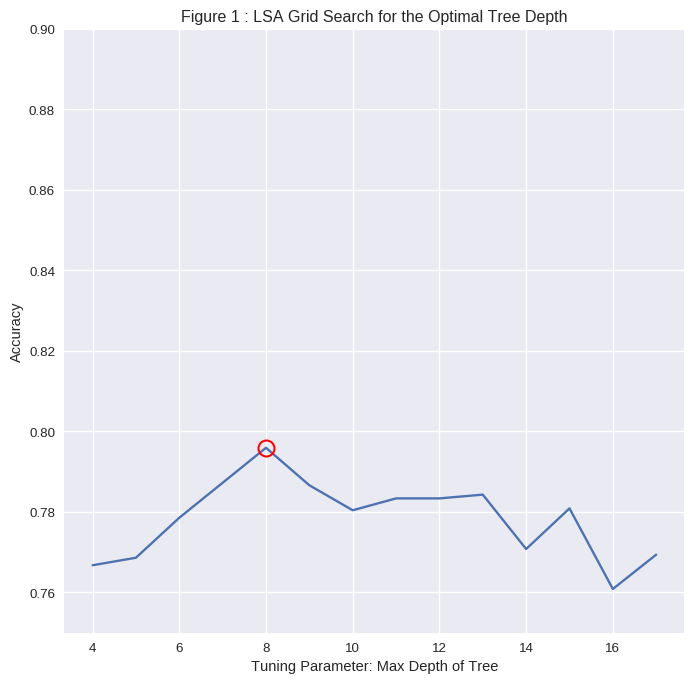

In [149]:
# Let us find the best value for depth of tree
# We want to run the whole dataset, so as not to overfit the model on the training data
rfc = ensemble.RandomForestClassifier()

y = tweet_data.target
X_tfidf = tfidf_vectorizer.fit_transform(tweets_doc)

print("  Actual number of tfidf features for the complete dataset: %d" % X_tfidf.get_shape()[1])
svd = TruncatedSVD(300)
X_lsa = svd.fit_transform(X_tfidf)

explained_variance = svd.explained_variance_ratio_.sum()
print("  Explained variance of the whole dataset SVD transformation: {}%".format(int(explained_variance * 100)))


print("  Actual number of LSA observations for the complete dataset: %d" % X_lsa.shape[0])
print("  Actual number of target observaions for the complete dataset: %d" % y.shape)

#==========================================
max_depth_range = list(range(4, 18))
param_grid = dict(max_depth=max_depth_range)

grid = GridSearchCV(rfc, param_grid, cv=5)
grid.fit(X_lsa, y)

# check the results of the grid search
#print(grid.grid_scores_)
grid.grid_scores_[1]
grid_mean_scores = [result[1] for result in grid.grid_scores_]
# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.75, .90])
plt.xlabel('Tuning Parameter: Max Depth of Tree')
plt.ylabel('Accuracy')
plt.plot(max_depth_range, grid_mean_scores)
plt.title('Figure 1 : LSA Grid Search for the Optimal Tree Depth')
__ = plt.plot(grid.best_params_['max_depth'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

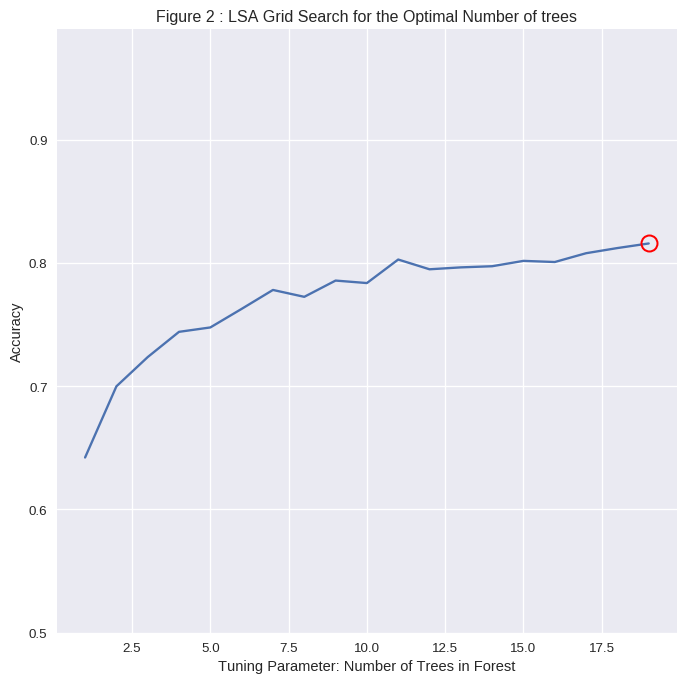

In [150]:
# Let us find the best value for the number of trees in the forest
rfc = ensemble.RandomForestClassifier(max_depth=8)

max_trees_range = list(range(1, 20))
param_grid = dict(n_estimators=max_trees_range)

grid = GridSearchCV(rfc, param_grid, cv=5)
grid.fit(X_lsa, y)


# check the results of the grid search
#print(grid.grid_scores_)
grid_mean_scores = [result[1] for result in grid.grid_scores_]

# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.50, 0.99])
plt.xlabel('Tuning Parameter: Number of Trees in Forest')
plt.ylabel('Accuracy')
plt.plot(max_trees_range, grid_mean_scores)
plt.title('Figure 2 : LSA Grid Search for the Optimal Number of trees')
__ = plt.plot(grid.best_params_['n_estimators'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

### Latent Semantic Analysis Model Building

Time Spent computing cross validation scores for LSA : 6.24 secs


[ 0.78310502  0.76258993  0.7901524   0.84848485  0.83986562  0.82084691
  0.82894737]
Accuracy: 0.81 (+/- 0.06)


Time Spent training Classifier : 0.62 secs
Prediction classes : 
 [0 1]

                 precision    recall  f1-score   support

 HillaryClinton       0.81      0.85      0.83      1284
realDonaldTrump       0.84      0.80      0.82      1294

    avg / total       0.83      0.83      0.83      2578





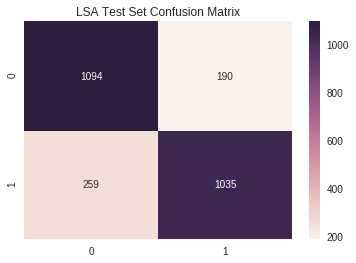

In [151]:
rfc = ensemble.RandomForestClassifier(max_depth=8, n_estimators=18)
target_names = ['HillaryClinton', 'realDonaldTrump']

with timeblock('Time Spent computing cross validation scores for LSA'):
    scores = cross_val_score(rfc, X_lsa, y, cv=7, scoring='f1')

print('\n')
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n\n" % (scores.mean(), scores.std() * 2))

__, cnfsn_mtrx = evaluate_model(rfc, X_train_lsa, y_train, X_test_lsa, y_test, target_names)

# Display heatmap of confusion matrix
__ = sb.heatmap(cnfsn_mtrx, annot=True, fmt="d")
__ = plt.title("LSA Test Set Confusion Matrix")

### Averaged Word Vectors 
Novel technique of weighing each matched word vector with the word TF-TDF score and summing up all the word vectors for a document and dividing it by the sum of all the TF-IDF weights of the matched words in the document. This would basically give us a TF-IDF weighted averaged word vector for each document [1].

In [128]:
# build word2vec model                   
model = gensim.models.Word2Vec(X_train, size=500, window=4, min_count=5, sample=1e-3)    

# Build features for Training and Test data
X_averaged_wv = averaged_word_vectorizer(corpus=tweets_doc,
                                                 model=model,
                                                 num_features=500)

model = gensim.models.Word2Vec(X_train, size=500, window=4, min_count=5, sample=1e-3)  

X_averaged_wv = averaged_word_vectorizer(corpus=tweets_doc,
                                                 model=model,
                                                 num_features=500)

### Averaged Word Vectors Hyper-parameter Tuning

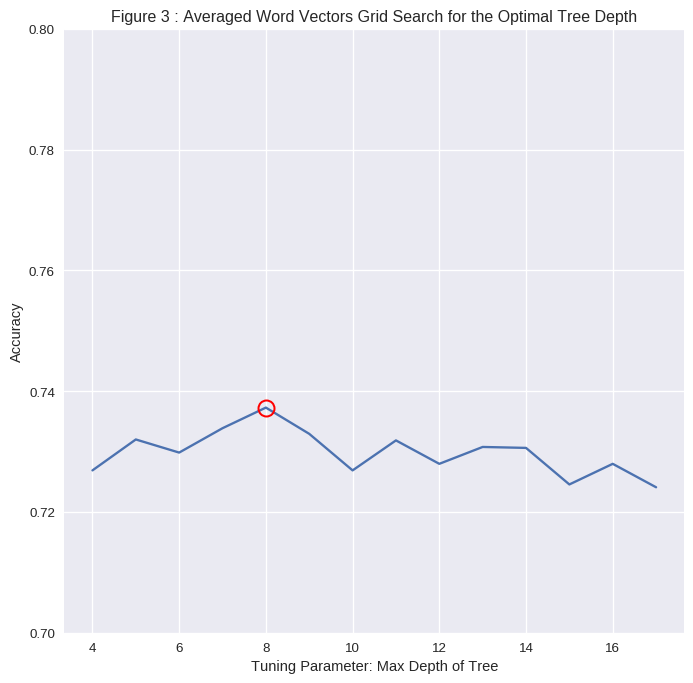

In [163]:
# build word2vec model for the entire data set                  
model = gensim.models.Word2Vec(tweets_doc, size=300, window=4, min_count=5, sample=1e-3)

X_averaged_wv = averaged_word_vectorizer(corpus=tweets_doc,
                                                 model=model,
                                                 num_features=300)
#====================================================
max_depth_range = list(range(4, 18))
param_grid = dict(max_depth=max_depth_range)

grid = GridSearchCV(rfc, param_grid, cv=5)
grid.fit(X_averaged_wv, y)

# check the results of the grid search
#print(grid.grid_scores_)
grid.grid_scores_[1]
grid_mean_scores = [result[1] for result in grid.grid_scores_]
# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.70, .80])
plt.xlabel('Tuning Parameter: Max Depth of Tree')
plt.ylabel('Accuracy')
plt.plot(max_depth_range, grid_mean_scores)
plt.title('Figure 3 : Averaged Word Vectors Grid Search for the Optimal Tree Depth')
__ = plt.plot(grid.best_params_['max_depth'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

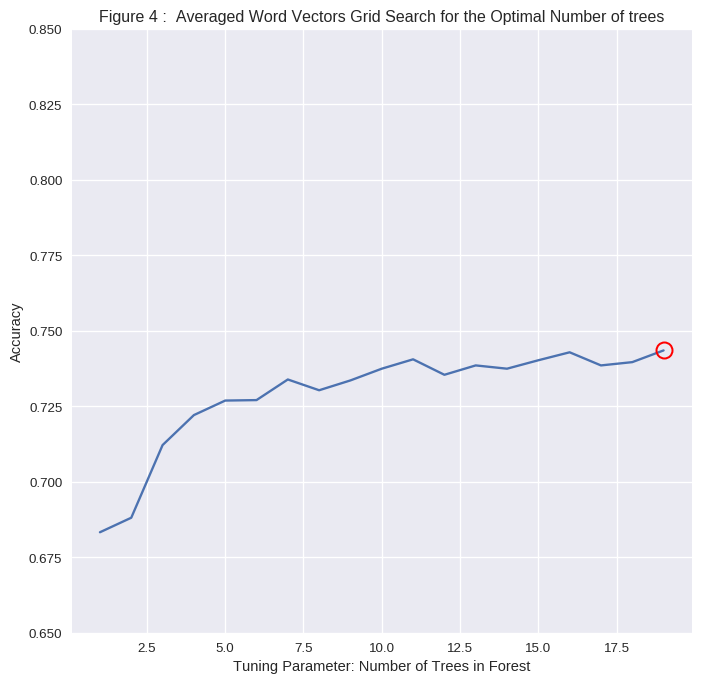

In [164]:
# Let us find the best value for the number of trees in the forest
rfc = ensemble.RandomForestClassifier(max_depth=8)

max_trees_range = list(range(1, 20))
param_grid = dict(n_estimators=max_trees_range)

grid = GridSearchCV(rfc, param_grid, cv=5)
grid.fit(X_averaged_wv, y)


# check the results of the grid search
#print(grid.grid_scores_)
grid_mean_scores = [result[1] for result in grid.grid_scores_]

# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.65, 0.85])
plt.xlabel('Tuning Parameter: Number of Trees in Forest')
plt.ylabel('Accuracy')
plt.plot(max_trees_range, grid_mean_scores)
plt.title('Figure 4 :  Averaged Word Vectors Grid Search for the Optimal Number of trees')
__ = plt.plot(grid.best_params_['n_estimators'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

In [ ]:
rfc = ensemble.RandomForestClassifier(max_depth=8, n_estimators=18)
target_names = ['HillaryClinton', 'realDonaldTrump']

with timeblock('Time Spent computing cross validation scores for LSA'):
    scores = cross_val_score(rfc, X_lsa, y, cv=7, scoring='f1')

print('\n')
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n\n" % (scores.mean(), scores.std() * 2))

__, cnfsn_mtrx = evaluate_model(rfc, X_train_lsa, y_train, X_test_lsa, y_test, target_names)

# Display heatmap of confusion matrix
__ = sb.heatmap(cnfsn_mtrx, annot=True, fmt="d")
__ = plt.title("Averaged Word Vectors Test Set Confusion Matrix")

## Discussion

## Conclusions

## References

1. Dipanjan Sarkar, (2016). Text Analytics with Python: A Practical Real-World Approach to Gaining Actionable Insights from Your Data. Retrieved from http://my.safaribooksonline.com/
